In [1]:
import kagglehub
import os
import cv2
import matplotlib.pyplot as plt
import shutil
import numpy as np

In [2]:
path = kagglehub.dataset_download("nexuswho/aitex-fabric-image-database")
print("Path to dataset files:", path)
print("Folders found:", os.listdir(path))

100%|██████████| 168M/168M [00:01<00:00, 93.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nexuswho/aitex-fabric-image-database/versions/1
Folders found: ['Defect_images', 'Mask_images', 'NODefect_images']


In [3]:
# Get list of defective images
defect_dir = os.path.join(path, 'Defect_images')
mask_dir = os.path.join(path, 'Mask_images')
filenames = os.listdir(defect_dir)

# Pick the first image to visualize
sample_img_name = filenames[0]
sample_mask_name = sample_img_name.replace('.png', '_mask.png') # AITEX naming convention

# Load images
img = cv2.imread(os.path.join(defect_dir, sample_img_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB for plotting
mask = cv2.imread(os.path.join(mask_dir, sample_mask_name), cv2.IMREAD_GRAYSCALE)

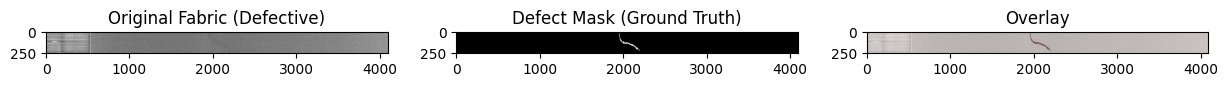

In [4]:
# Plotting
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Fabric (Defective)")
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.title("Defect Mask (Ground Truth)")
plt.imshow(mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(img)
plt.imshow(mask, alpha=0.5, cmap='Reds')
# Overlay mask on image
plt.show()

In [5]:
#The output confirms the data is loaded, but it highlights a massive problem that fabric images are 4096 * 256 pixels therefore to fix this we will patch our images
#chopping each long strip into 16 sq patches of 256*256 pixels

In [6]:
# Create new directory structure
os.makedirs('processed_data/Defect', exist_ok=True)
os.makedirs('processed_data/NoDefect', exist_ok=True)

def create_patches(img_dir, mask_dir, patch_size=256):
    defect_count = 0
    no_defect_count = 0

    filenames = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    for fname in filenames:
        img = cv2.imread(os.path.join(img_dir, fname))
        # Mask naming in AITEX: image 0001.png -> mask 0001_mask.png
        mask_name = fname.replace('.png', '_mask.png')
        mask = cv2.imread(os.path.join(mask_dir, mask_name), cv2.IMREAD_GRAYSCALE)

        if mask is None: continue

        # Slice the 4096 width into 16 patches of 256
        for i in range(0, img.shape[1], patch_size):
            patch = img[:, i:i+patch_size]
            mask_patch = mask[:, i:i+patch_size]

            # If any white pixel exists in the mask patch, it's a defect
            if np.any(mask_patch > 0):
                cv2.imwrite(f'processed_data/Defect/{fname}_{i}.png', patch)
                defect_count += 1
            else:
                cv2.imwrite(f'processed_data/NoDefect/{fname}_{i}.png', patch)
                no_defect_count += 1

    print(f"Created {defect_count} Defective patches and {no_defect_count} Healthy patches.")

# Run the function
create_patches(os.path.join(path, 'Defect_images'), os.path.join(path, 'Mask_images'))

Created 183 Defective patches and 1464 Healthy patches.


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
defect_path = 'processed_data/Defect/'
save_path = 'processed_data/Defect_Augmented/'
os.makedirs(save_path, exist_ok=True)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
for fname in os.listdir(defect_path):
    img = cv2.imread(os.path.join(defect_path, fname))
    img = img.reshape((1,) + img.shape) # Reshape for the generator

    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=save_path,
                              save_prefix='aug', save_format='png'):
        i += 1
        if i > 5: # Create 5 augmented images for every 1 original
            break

print(f"Augmentation complete. Check the '{save_path}' folder!")

Augmentation complete. Check the 'processed_data/Defect_Augmented/' folder!


In [8]:
original_defect_count = len(os.listdir('processed_data/Defect'))
augmented_defect_count = len(os.listdir('processed_data/Defect_Augmented'))
healthy_count = len(os.listdir('processed_data/NoDefect'))

print(f"Original Defects: {original_defect_count}")
print(f"Augmented Defects: {augmented_defect_count}")
print(f"Healthy Samples: {healthy_count}")

Original Defects: 183
Augmented Defects: 1034
Healthy Samples: 1464


In [9]:
!pip install split-folders
import splitfolders
# 1. Create a final staging area
os.makedirs('final_dataset/Defect', exist_ok=True)
os.makedirs('final_dataset/NoDefect', exist_ok=True)

# 2. Move all defect images (Original + Augmented) into the staging folder
# We use a loop to handle the two different source folders you created
for folder in ['processed_data/Defect', 'processed_data/Defect_Augmented']:
    for fname in os.listdir(folder):
        shutil.copy(os.path.join(folder, fname), 'final_dataset/Defect')

# 3. Move all healthy images into the staging folder
for fname in os.listdir('processed_data/NoDefect'):
    shutil.copy(os.path.join('processed_data/NoDefect', fname), 'final_dataset/NoDefect')

# 4. Perform the Split (80% Train, 10% Val, 10% Test)
splitfolders.ratio("final_dataset", output="train_test_data",
                   seed=1337, ratio=(.8, .1, .1), move=False)

Copying files: 2681 files [00:01, 2067.19 files/s]


In [10]:
from tensorflow.keras import layers, models

# 1. Setup constants
IMG_SIZE = (256, 256)
CHANNELS = 3 # RGB

# 2. Load the "Pre-trained" base (MobileNetV2)
# include_top=False means we throw away the "original" brain and keep the "eyes"
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

# 3. Freeze the base model (Don't let the AI change the "eyes" yet)
base_model.trainable = False

# 4. Build the final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Flattens the image data into a simple vector
    layers.Dense(128, activation='relu'), # A hidden layer to "think" about the features
    layers.Dropout(0.2), # Prevents the AI from "memorizing" (overfitting)
    layers.Dense(1, activation='sigmoid') # Final output: 0 (No Defect) or 1 (Defect)
])

# 5. Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', # Used because we only have 2 classes
    metrics=['accuracy']
)

model.summary()

/tmp/ipython-input-1095575845.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
#UserWarning came because TensorFlow was originally trained on 224 * 224 images, but since we are using it as a "feature extractor" without the top layer, it will adapt to our 256 * 256 patches perfectly fine.

In [12]:
# Define how much the AI studies at once (Batch Size)
BATCH_SIZE = 32

# Load Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    'train_test_data/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    'train_test_data/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Load Test Data (The final exam)
test_ds = tf.keras.utils.image_dataset_from_directory(
    'train_test_data/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Performance tuning: keep the images in memory for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 2144 files belonging to 2 classes.
Found 267 files belonging to 2 classes.
Found 270 files belonging to 2 classes.


In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9297 - loss: 0.1714 - val_accuracy: 0.9176 - val_loss: 0.2369
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9416 - loss: 0.1572 - val_accuracy: 0.8989 - val_loss: 0.2662
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9408 - loss: 0.1586 - val_accuracy: 0.9101 - val_loss: 0.2482
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9395 - loss: 0.1674 - val_accuracy: 0.9176 - val_loss: 0.2475
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9388 - loss: 0.1599 - val_accuracy: 0.9176 - val_loss: 0.2554
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9365 - loss: 0.1543 - val_accuracy: 0.9251 - val_loss: 0.2859
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9266 - loss: 0.1936 - val_accuracy: 0.9213 - val_loss: 0.2465
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9449 - loss: 0.1541 - val_accuracy: 0.9251 - v

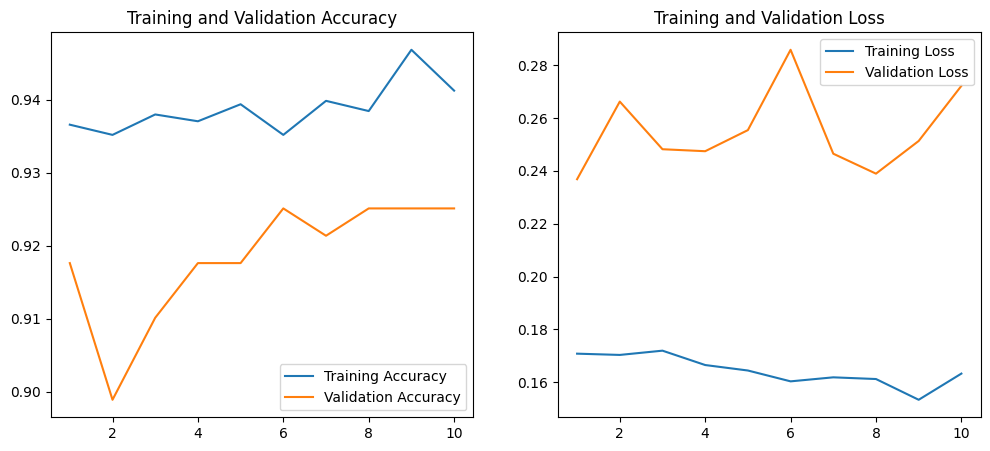

In [15]:
#Visualizing the Training Progress
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.show()

In [16]:
#Final Evaluation & Saving

# 1. Evaluate on the Test Set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

# 2. Save the model to your Colab files
model.save('fabric_defect_model.h5')
print("Model saved as fabric_defect_model.h5")

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9548 - loss: 0.1617


Final Test Accuracy: 93.70%
Model saved as fabric_defect_model.h5


In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_fabric():
    print("Please upload a fabric patch (256x256) to test...")
    uploaded = files.upload()

    for fn in uploaded.keys():
        # 1. Load and display the image
        img = image.load_img(fn, target_size=(256, 256))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # 2. Prepare the image for the AI
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0 # Normalize pixels to [0,1]

        # 3. Predict
        prediction = model.predict(img_array)

        # 4. Show Result
        if prediction[0] > 0.5:
            confidence = prediction[0][0] * 100
            print(f"RESULT: DEFECT DETECTED ({confidence:.2f}% confidence)")
        else:
            confidence = (1 - prediction[0][0]) * 100
            print(f"RESULT: FABRIC IS HEALTHY ({confidence:.2f}% confidence)")

# Execute the tester
predict_fabric()

Please upload a fabric patch (256x256) to test...
